# Liquidación de Divisas por Exportaciones de Oleaginosas y Cereales - ETL y Análisis Exploratorio

En este notebook llevaremos a cabo el proceso de **Extracción, Transformación y Carga (ETL)** del dataset de **liquidación de divisas por exportaciones de oleaginosas y cereales**.  
Posteriormente, realizaremos un **Análisis Exploratorio de Datos (EDA)** sobre la serie tratada.  

El objetivo es preparar la información para su posterior uso en un proyecto de **Power BI (.pbix)** y extraer insights relevantes desde este entorno.

### Pregunta guía

> **¿Existe algún patrón que permita predecir el volumen de las liquidaciones mensuales desde 2003 hasta la actualidad?**

Todo el análisis estará orientado a responder esta pregunta de forma gradual y estructurada.


## 1. Serie de tiempo seleccionada

Trabajaremos con un dataset proveniente de [Datos.gob.ar](https://datos.gob.ar/dataset/sspm-liquidacion-divisas-por-exportaciones-oleaginosas-cereales/archivo/sspm_349.2), que registra la **liquidación de divisas por exportaciones de oleaginosas y cereales** desde **enero de 2003 hasta la actualidad**.  
Esta serie mensual es fundamental para analizar patrones estacionales, tendencias históricas y eventos relevantes en el sector agroexportador argentino.

### Carga del dataset original

A continuación, cargamos el archivo `.csv` que contiene los datos anuales de la liquidación de divisas.  
El archivo fue previamente descargado y subido al entorno de Colab. Se utiliza la biblioteca **Pandas** para su lectura.

> **Nota:** Nos aseguramos de que el archivo tenga una codificación `utf-8` para evitar errores de caracteres especiales.


## 2. Carga del dataset

Importamos el archivo `.csv` utilizando la librería **Pandas**, asegurando la correcta codificación en `utf-8`.  
Este dataset será la base para el proceso de limpieza y análisis posterior.


In [ ]:
import pandas as pd

ruta = "/content/liquidacion-divisas-exportaciones-oleaginosas-cereales-mensual.csv"

# Leer el archivo .csv
df_original = pd.read_csv(ruta, encoding="utf-8")

## 3. Exploración inicial

Visualizamos las primeras filas del dataset para validar la estructura de los datos y confirmar que la carga se haya realizado correctamente.


In [ ]:
# Mostrar primeras filas
df_original.head()

,indice_tiempo,acum_mensual,promedio_diario
0,2003-01-01,648.346805,29.470309
1,2003-02-01,429.309485,21.465474
2,2003-03-01,633.353409,31.667670
3,2003-04-01,866.749669,43.337483
4,2003-05-01,1093.831665,52.087222


### Descripción de las columnas principales

- **indice_tiempo**: Fecha correspondiente al mes reportado (formato `YYYY-MM-01`).
- **acum_mensual**: Monto total liquidado durante el mes, en millones de dólares.
- **promedio_diario**: Promedio diario de liquidación en el mes, en millones de dólares por día.


## 4. Preparación del dataset

Seleccionamos y renombramos las columnas relevantes para el análisis:

- `indice_tiempo` → `fecha` (convertida a tipo `datetime`)
- `acum_mensual` → `liq_mes` (convertida a tipo `int`)

Esta transformación nos permite trabajar con un dataset más limpio y estructurado para el análisis posterior.


In [ ]:
#Copiamos el archivo original
df_v1 = df_original[['indice_tiempo', 'acum_mensual']].copy()

#seleccionamos las columnas que vamos a usar, las renombramos y casteamos según necesidad
df_v1 = df_v1.rename(columns={'indice_tiempo': 'fecha', 'acum_mensual': 'liq_mensual'})
df_v1['fecha'] = pd.to_datetime(df_v1['fecha'])
df_v1['liq_mensual'] = df_v1['liq_mensual'].astype(int)

#veamos el nuevo df
df_v1

,fecha,liq_mensual
0,2003-01-01,648
1,2003-02-01,429
2,2003-03-01,633
3,2003-04-01,866
4,2003-05-01,1093
...,...,...
261,2024-10-01,2553
262,2024-11-01,1999
263,2024-12-01,1966
264,2025-01-01,2073


## 2. Exploración inicial y limpieza de la Serie de Tiempo

Antes de avanzar con el Análisis Exploratorio, verificaremos la integridad del dataset.

Los pasos serán:

1. Confirmar los tipos de datos.
2. Establecer el índice como `datetime` (formato de Serie de Tiempo).
3. Identificar y tratar registros duplicados.
4. Detectar y manejar datos faltantes.

Comenzamos verificando los tipos de datos disponibles.


### 2.1 Verificación de tipos de datos y establecimiento del índice

Verificamos que las columnas tengan el tipo de dato adecuado.  
Luego, establecemos `fecha` como índice para poder trabajar correctamente como Serie de Tiempo en Pandas.


In [ ]:
# Verificar tipos de datos (cantidades numéricas)

# Establecemos la columna 'fecha' como índice
df_v1.set_index('fecha', inplace=True)

#Veamos
df_v1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 266 entries, 2003-01-01 to 2025-02-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   liq_mensual  266 non-null    int64
dtypes: int64(1)
memory usage: 4.2 KB


### 2.2 Verificación del tipo de índice

Confirmamos que el índice del dataframe (`fecha`) sea de tipo `datetime64[ns]`, requisito fundamental para operar como Serie de Tiempo en Pandas.


In [ ]:
# Verificar que el índice es de tipo "datetime"
df_v1.index

DatetimeIndex(['2003-01-01', '2003-02-01', '2003-03-01', '2003-04-01',
               '2003-05-01', '2003-06-01', '2003-07-01', '2003-08-01',
               '2003-09-01', '2003-10-01',
               ...
               '2024-05-01', '2024-06-01', '2024-07-01', '2024-08-01',
               '2024-09-01', '2024-10-01', '2024-11-01', '2024-12-01',
               '2025-01-01', '2025-02-01'],
              dtype='datetime64[ns]', name='fecha', length=266, freq=None)

### 2.3 Verificación de registros duplicados

Comprobamos si existen filas duplicadas en el dataset.  
Un resultado `False` indica que no se encontraron duplicados.
Verifiquemos si existen registros (filas) duplicados:

In [ ]:
df_v1.duplicated().any()

np.True_

Lo importante es verificar que no existen fechas duplicadas, pues por cada día debemos tener un único registro de precio de cierre.

Esto lo podemos verificar accediendo al método `duplicated()` del índice:

In [ ]:
# Verificar si hay fechas duplicadas en el índice
df_v1.index.duplicated().any()

np.False_

No tenemos fechas duplicadas así que la Serie de Tiempo tiene una estructura correcta.

Verifiquemos si hay datos faltantes (celdas vacías en la columna *liq_mensual*):

### 2.4 Verificación de datos faltantes

Revisamos si existen valores nulos en las columnas del dataset.  
Un resultado de cero en todas las columnas confirma que no hay datos faltantes.


In [ ]:
# Verificar si hay datos faltantes
df_v1.isna().sum()

,0
liq_mensual,0


Tampoco hay datos faltantes.

Así que en este punto ya hemos verificado la integridad de la Serie de Tiempo y podemos comenzar a hacer el Análisis Exploratorio.

### A continuación: el .csv con el que realizaremos los tableros .pbix

## 3. Exportación del dataset limpio

Guardamos el dataframe procesado en un archivo `.csv` para su posterior utilización en proyectos de análisis y visualización, como Power BI.  
A continuación, descargamos el archivo generado.


In [ ]:
# Guardar y descargar el dataset limpio

# Exportamos el DataFrame a un archivo CSV
df_v1.to_csv("liquidacion-divisas-exportaciones-oleaginosas-cereales-mensual_cleaned.csv")

# Descargamos el archivo generado
from google.colab import files
files.download("liquidacion-divisas-exportaciones-oleaginosas-cereales-mensual_cleaned.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 3. Análisis Exploratorio de la Serie de Tiempo

El Análisis Exploratorio (EDA) nos permitirá entender el comportamiento de la serie de tiempo mediante estadísticas descriptivas, herramientas gráficas y observaciones estructuradas.

Todo análisis debe partir de una pregunta guía. En este caso:

> ¿Existe algún patrón que permita predecir el volumen de las liquidaciones mensuales desde 2003 hasta la actualidad?

Iremos abordando esta pregunta progresivamente, comenzando por la visualización general de la serie de tiempo.

### 3.1 Visualización general de la Serie de Tiempo

Graficamos el volumen mensual de liquidaciones para identificar tendencias, estacionalidades y posibles anomalías a lo largo del período analizado (2003–actualidad).


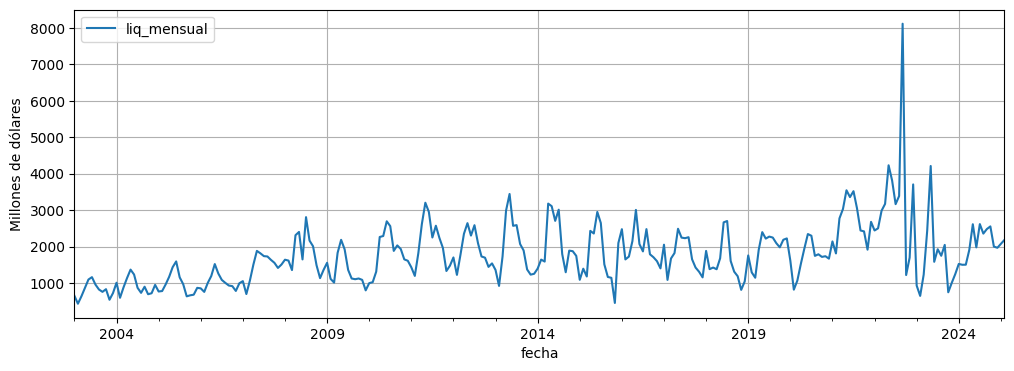

In [ ]:
ax = df_v1.plot(figsize=(12,4))
ax.grid()
ax.set_ylabel('Millones de dólares');

### Nota: visualización inicial de la Serie de Tiempo

- Se observa una **tendencia creciente** en el volumen de liquidaciones entre 2003 y 2022.
- A partir de **2020** la serie muestra **mayor volatilidad**.
- **Septiembre de 2022** presenta un **pico máximo histórico**.
- Existen **patrones estacionales** evidentes, con aumentos recurrentes en determinados meses.

### 3.2 Estadística descriptiva de la Serie de Tiempo

Aplicamos el método `describe()` de Pandas para obtener un resumen numérico del comportamiento global de la serie, incluyendo medidas de tendencia central, dispersión y extremos.


In [ ]:
df_v1.describe().round(0)

,liq_mensual
count,266.0
mean,1766.0
std,838.0
min,429.0
25%,1155.0
50%,1658.0
75%,2243.0
max,8120.0


### Nota: resumen estadístico de la Serie de Tiempo

- El volumen mínimo mensual fue de **429M** (inicio del período) y el máximo de **8.120M** (septiembre 2022), reflejando una variación del **1.793%**.
- La **media** fue de **1.766M** y la **desviación estándar** de **838M**, lo que evidencia una **alta volatilidad** en las liquidaciones mensuales.


## 3.3 Suavizado de la Serie: Media Móvil

Para analizar la tendencia general de la serie y eliminar variaciones rápidas, aplicaremos una **media móvil**.  
Calcularemos promedios sobre una ventana de **12 meses** utilizando los métodos `rolling()` y `mean()` de Pandas.

In [ ]:
df_v1['media_movil'] = df_v1['liq_mensual'].rolling(window=12).mean()
df_v1

,liq_mensual,media_movil
fecha,,
2003-01-01,648,NaN
2003-02-01,429,NaN
2003-03-01,633,NaN
2003-04-01,866,NaN
2003-05-01,1093,NaN
...,...,...
2024-10-01,2553,1939.250000
2024-11-01,1999,2022.250000
2024-12-01,1966,2082.416667


Y ahora podemos dibujar un gráfico que contenta el comportamiento mes a mes del volumen  y superponer a este la media móvil recién calculada:

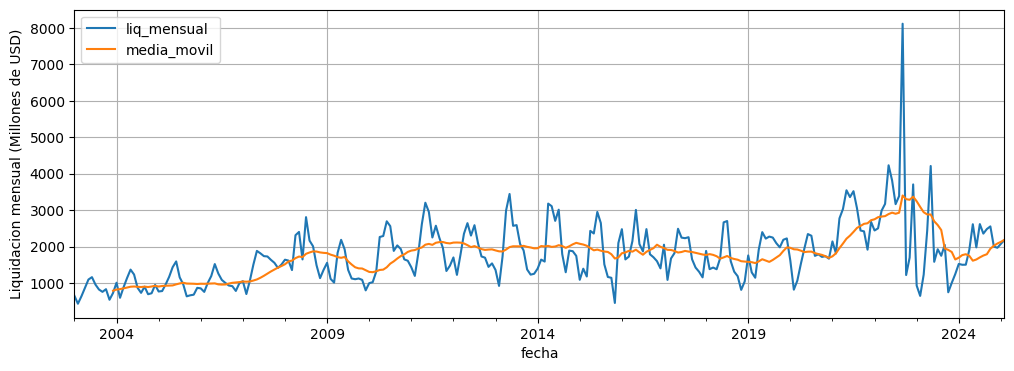

In [ ]:
ax = df_v1.plot(figsize=(12,4))
ax.grid()
ax.set_ylabel('Liquidacion mensual (Millones de USD)');

### Nota: suavizado de la Serie de Tiempo con media móvil

- La media móvil anual suaviza las fluctuaciones mensuales, permitiendo visualizar la **tendencia subyacente** de largo plazo.
- Se confirma una **tendencia creciente** en las liquidaciones hasta 2022, seguida por una fuerte caída en 2023.
- A pesar de los picos y caídas mensuales, la tendencia general refleja **ciclos de crecimiento y contracción** a lo largo del tiempo.
- La media móvil es menos sensible a eventos extremos, ofreciendo una visión más clara de la evolución estructural del sector.

### 3.4 Variación porcentual respecto a la media móvil

Calculamos la variación porcentual absoluta entre el valor mensual de liquidaciones y su media móvil anual.  
Esto nos permitirá medir la **volatilidad relativa** respecto a la tendencia de largo plazo.


In [ ]:
df_v1['cambio_%'] = 100*abs((df_v1['liq_mensual']-df_v1['media_movil'])/(df_v1['media_movil']))
df_v1

,liq_mensual,media_movil,cambio_%
fecha,,,
2003-01-01,648,NaN,NaN
2003-02-01,429,NaN,NaN
2003-03-01,633,NaN,NaN
2003-04-01,866,NaN,NaN
2003-05-01,1093,NaN,NaN
...,...,...,...
2024-10-01,2553,1939.250000,31.648833
2024-11-01,1999,2022.250000,1.149709
2024-12-01,1966,2082.416667,5.590460


Y veamos el comportamiento de este cambio porcentual junto con la Serie original y su media móvil:

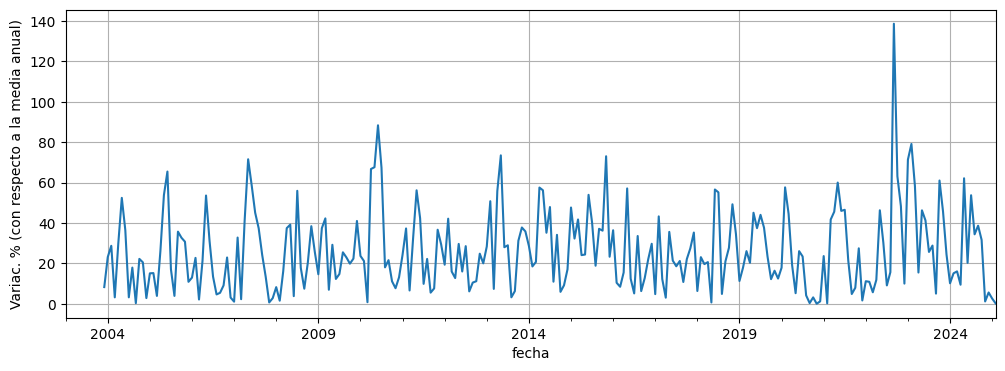

In [ ]:
ax = df_v1['cambio_%'].plot(figsize=(12,4))
ax.grid()
ax.set_ylabel('Variac. % (con respecto a la media anual)');

### Nota: variación porcentual respecto a la media móvil

- La volatilidad relativa tiende a ser **moderada** durante gran parte del período, con variaciones entre el **20% y 40%**.
- Se identifican **picos extremos** de variación en torno a eventos específicos, destacándose **septiembre de 2022**.
- A partir de 2020, la frecuencia de **variaciones abruptas** aumenta, reflejando un contexto de mayor inestabilidad.
- En los últimos meses, la variabilidad disminuye, lo que podría señalar una **fase de estabilización** reciente.

### 3.5 Variación porcentual con línea de promedio

Añadimos una línea discontinua roja que representa el **promedio histórico** de la variación porcentual.  
Esto nos permite identificar de forma rápida los períodos en los que la volatilidad estuvo **por encima o por debajo** del comportamiento medio.


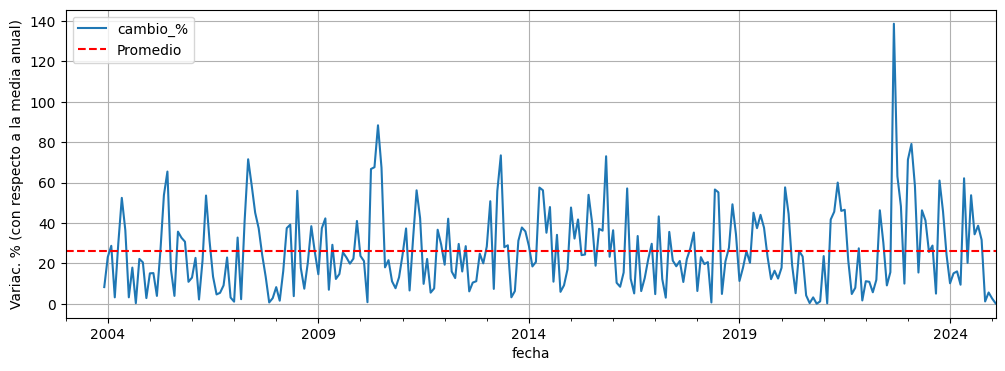

In [ ]:
ax = df_v1['cambio_%'].plot(figsize=(12,4))

# Añadir promedio
ax.hlines(df_v1['cambio_%'].mean(),xmin=df_v1.index.min(), xmax=df_v1.index.max(),
          color='r', linestyle='--', label='Promedio')
ax.grid()
ax.legend()
ax.set_ylabel('Variac. % (con respecto a la media anual)');

### Nota: análisis de la variación porcentual respecto al promedio

- El promedio histórico de la variación porcentual ronda el **26%**.
- La mayoría de los meses presentan **variaciones cercanas o inferiores** a este promedio.
- Se observan **picos esporádicos** muy por encima del promedio, asociados a eventos extraordinarios.
- La volatilidad tiende a **concentrarse en períodos recientes**, reflejando mayor inestabilidad económica.


### 3.6 Análisis de la distribución de la variación porcentual

Generamos un boxplot para visualizar la distribución de la variación porcentual respecto a la media móvil.  
Esta herramienta nos permite identificar la **dispersión**, la **asimetría** y la presencia de **outliers** de forma gráfica.


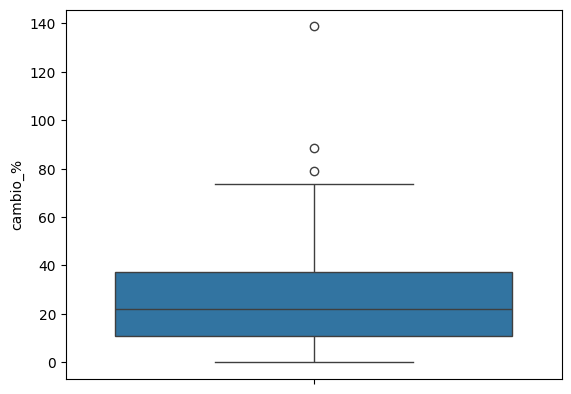

In [ ]:
import seaborn as sns

sns.boxplot(df_v1['cambio_%']);

### Nota: interpretación del boxplot de la variación porcentual

- La mayoría de las variaciones porcentuales se encuentran entre el **10% y el 40%**.
- La **mediana** está próxima al **20%**, en línea con el promedio histórico.
- Se identifican varios **outliers** por encima del 75º percentil, indicando meses de volatilidad excepcionalmente alta.
- La distribución presenta **ligera asimetría positiva**, reflejando que los eventos de alta variabilidad son menos frecuentes pero más intensos.


### 3.7 Identificación de valores extremos

Filtramos los registros donde la variación porcentual supera el **75%**, considerados eventos extraordinarios.  
Estos valores representan meses de **alta volatilidad** en relación a su media anual.


In [ ]:
# Buscar valores extremos
outliers = df_v1[df_v1['cambio_%']>75]['liq_mensual']
outliers

,liq_mensual
fecha,
2010-06-01,2693
2022-09-01,8120
2023-02-01,644


### 3.8 Visualización de valores extremos en la Serie de Tiempo

Graficamos la serie original de liquidaciones mensuales y resaltamos en rojo los meses identificados como outliers.  
Esto permite visualizar cuándo ocurrieron los eventos de **mayor desviación** respecto al comportamiento esperado.


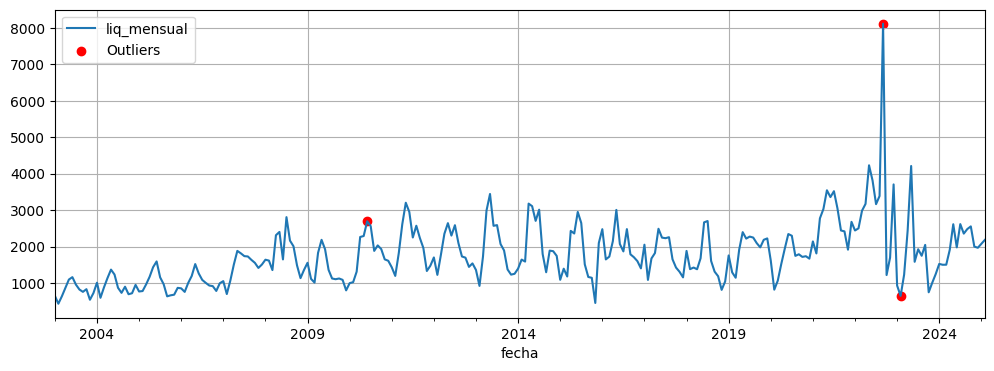

In [ ]:
# Graficar serie de tiempo original
ax = df_v1['liq_mensual'].plot(figsize=(12,4))

# Y superponer (en rojo) los valores extremos
ax.scatter(outliers.index, outliers, color='r', label='Outliers')

# Grilla y etiquetas
ax.legend()
ax.grid();

### Nota: interpretación de los valores extremos

- Los outliers identificados corresponden a meses con **desviaciones inusualmente altas** respecto a la tendencia esperada.
- El pico de septiembre de 2022 representa el **máximo histórico** de liquidaciones registrado en el período analizado.
- La caída posterior en 2023 también se destaca como un **evento atípico de bajo volumen**.
- Estas anomalías marcan momentos críticos para el sector, vinculados probablemente a **medidas económicas o condiciones climáticas excepcionales**.


### 3.9 Análisis de la volatilidad con desviación estándar móvil

Calculamos la **desviación estándar móvil** con una ventana de 12 meses para evaluar cómo varió la volatilidad de las liquidaciones a lo largo del tiempo.  
Esto nos permite identificar períodos de **mayor o menor dispersión** respecto a la media anual.


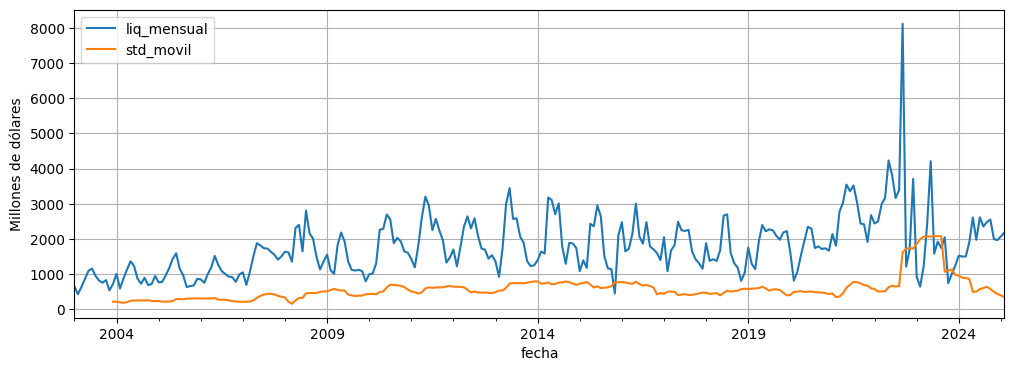

In [ ]:
df_v1['std_movil'] = df_v1['liq_mensual'].rolling(window=12).std()

# Graficar
ax = df_v1[['liq_mensual','std_movil']].plot(figsize=(12,4))

# Ajustar gráfica
ax.legend()
ax.grid()
ax.set_ylabel('Millones de dólares');

### Nota: interpretación de la volatilidad en la Serie de Tiempo

- Entre 2003 y 2018, la volatilidad se mantuvo **relativamente baja y estable**.
- A partir de 2019 se observa un **incremento progresivo en la dispersión** de los valores.
- El pico de volatilidad coincide con el **récord de liquidaciones de septiembre 2022**.
- Tras 2023, la volatilidad disminuye, sugiriendo una posible **fase de estabilización** reciente en los volúmenes liquidados.


### 3.10 Evolución anual de la volatilidad

Graficamos la desviación estándar móvil utilizando un gráfico de barras para observar de forma más clara la evolución de la volatilidad a lo largo del tiempo.  
Esta representación facilita la comparación visual de los niveles de dispersión entre distintos períodos.


Podemos usar también gráficos de barras para ver este comportamiento de la volatilidad un poco más en detalle:

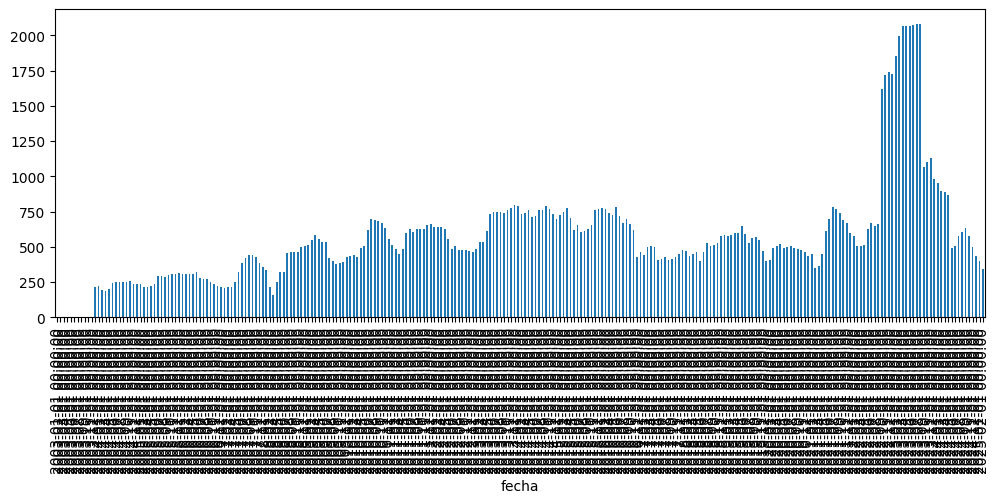

In [ ]:
df_v1['std_movil'].plot.bar(figsize=(12,4));

### Nota: necesidad de remuestrear la Serie de Tiempo

- Graficar la volatilidad con frecuencia mensual genera una visualización **sobrecargada y poco interpretable**.
- La cantidad de registros mensuales entre 2003 y 2025 es demasiado alta para un análisis visual efectivo.
- Para obtener un panorama más claro y sintetizado, es recomendable **remuestrear la Serie de Tiempo a frecuencia anual**.


### 3.11 Volatilidad anual promedio

Aplicamos un remuestreo anual para calcular la media de la desviación estándar móvil en cada año.  
Esto permite visualizar de manera más precisa cómo evolucionó la **volatilidad promedio anual** a lo largo del tiempo.


<ipython-input-31-378e97d5828f>:3: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_v1_anual = df_v1.resample('Y').mean()


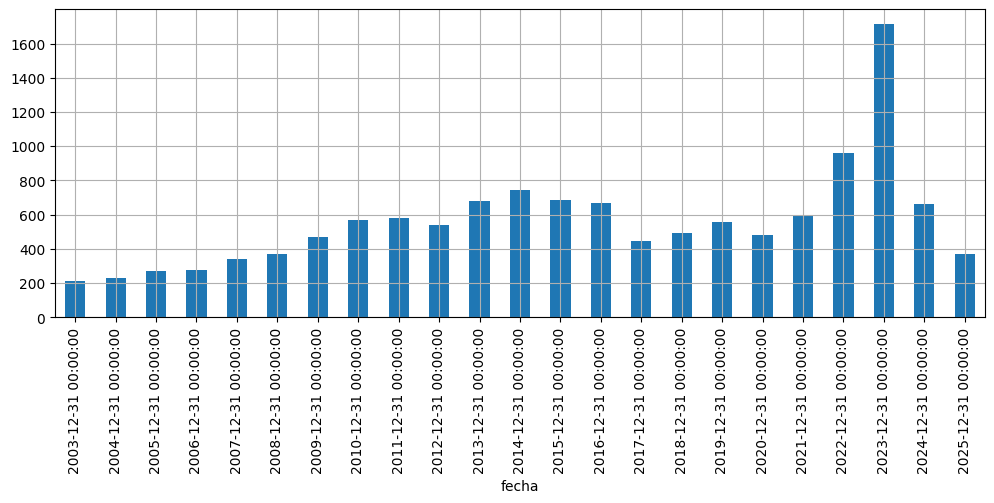

In [ ]:
# Remuestreo anual. Por cada año se calculará la media de
# cada variable
df_v1_anual = df_v1.resample('Y').mean()

# Y ahora sí generemos el gráfico
ax = df_v1_anual['std_movil'].dropna().plot.bar(figsize=(12,4));
ax.grid()

### Nota: evolución de la volatilidad promedio anual

- La volatilidad muestra un **crecimiento sostenido** desde 2003 hasta 2014, con un leve descenso posterior.
- A partir de 2020, se observa un **fuerte aumento**, alcanzando el **máximo en 2022**.
- El incremento de 2022 coincide con los **eventos extremos** ya detectados en la serie.
- En 2024-2025, la volatilidad muestra una **tendencia a la baja**, señalando una posible normalización del comportamiento de las liquidaciones.


### 3.12 Análisis de autocorrelación (ACF)

Calculamos y graficamos la **Función de Autocorrelación (ACF)** para analizar la dependencia temporal de la serie de liquidaciones mensuales.  
Esto permite identificar patrones repetitivos, persistencia de tendencias y posibles componentes estacionales.


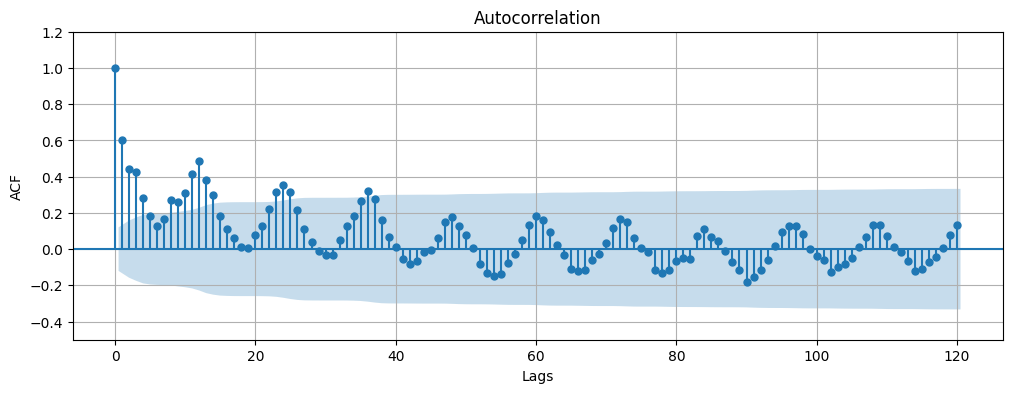

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Calcular y generar gráfico
fig, ax = plt.subplots(figsize=(12, 4))
sm.graphics.tsa.plot_acf(df_v1['liq_mensual'].dropna(), lags=120, ax=ax)
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.grid(True)
plt.ylim([-0.5,1.2]);

### Nota: interpretación de la autocorrelación

- Existe una **alta autocorrelación inicial**, lo que indica que los valores mensuales están fuertemente relacionados con sus valores inmediatos anteriores.
- Se observan **patrones cíclicos** aproximadamente cada 12 lags, sugiriendo una posible **estacionalidad anual**.
- La autocorrelación disminuye gradualmente, mostrando **persistencia** en la serie pero con una caída moderada en el largo plazo.
- Estos resultados respaldan la existencia de **tendencias y estacionalidad** en la liquidación de divisas a lo largo del tiempo.


# 4. Resumen general del Análisis Exploratorio

El objetivo de este análisis exploratorio fue investigar si existe algún patrón que permita predecir el volumen de liquidaciones mensuales de divisas desde 2003 hasta la actualidad.  
A partir del estudio realizado, destacamos los siguientes hallazgos:

- **Tendencia estructural**: Se observó una tendencia creciente en los volúmenes liquidados entre 2003 y 2022, seguida de una fuerte caída a partir de 2023.

- **Volatilidad**: A partir de 2020, la volatilidad aumentó de forma considerable, especialmente en 2022, complicando la estabilidad de las predicciones en los últimos años.

- **Eventos atípicos**: Se identificaron outliers vinculados a eventos macroeconómicos o cambios de política, los cuales deberán ser tratados explícitamente en futuros modelos.

- **Patrones estacionales**: El análisis de autocorrelación reveló una **estacionalidad anual clara**, con picos de liquidaciones recurrentes alrededor de los meses de cosecha gruesa (marzo a junio).

- **Persistencia temporal**: Los altos niveles de autocorrelación en los primeros lags muestran que el volumen de liquidaciones de un mes depende fuertemente de los valores de meses anteriores, favoreciendo el uso de modelos autoregresivos.

### Patrones detectados aprovechables para predicción futura:

- **Tendencia de crecimiento a largo plazo** (con ajuste por la caída post-2022).
- **Estacionalidad anual** con patrones cíclicos alrededor de ciertos meses específicos (marzo a junio).
- **Alta autocorrelación mensual** que sugiere que valores recientes son buenos predictores de valores futuros.

### Conclusión

**Sí**, existen patrones de tendencia, estacionalidad y persistencia que pueden ser aprovechados para modelar y predecir el comportamiento de las liquidaciones mensuales.  
Será fundamental considerar la volatilidad reciente y los eventos atípicos para lograr modelos robustos y realistas.


# 5. Próximos pasos sugeridos

A partir de los hallazgos obtenidos en el Análisis Exploratorio, se recomienda avanzar con las siguientes acciones:

- **Tratamiento de outliers**: Analizar el impacto de los valores atípicos detectados y decidir su tratamiento (incluirlos, atenuarlos o eliminarlos según el objetivo del modelo).

- **Evaluación de estabilidad**: Comparar la estabilidad de patrones antes y después de 2020 para decidir si es necesario construir modelos diferenciados por período.

- **Visualización avanzada**: Integrar los resultados y métricas clave en un dashboard de Power BI, facilitando la interpretación y monitoreo dinámico de las liquidaciones.

Cada una de estas acciones contribuirá a construir predicciones más robustas, realistas y adaptadas a la dinámica actual del mercado.
